In [16]:
from scipy import stats
import pandas as pd
import numpy as np

data = pd.read_csv('pokemon.csv')

### Correlation Metrics

##### Pearson

The Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y. According to the Cauchy–Schwarz inequality it has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

$$
{\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}
$$

In [11]:
# Using scipy, between two values (p-value only useful for n > 500)
corr_coeff, p_value = stats.pearsonr(data['Attack'], data['Defense'])

print('The correlation coefficient is {} with a {} p-value'.format(corr_coeff, p_value))

The correlation coefficient is 0.43868705511848954 with a 5.858479864288463e-39 p-value


In [17]:
# Using pandas, between all columns
data[['Attack', 'HP', 'Defense', 'Speed']].corr(method='pearson')

,Attack,HP,Defense,Speed
Attack,1.000000,0.422386,0.438687,0.381240
HP,0.422386,1.000000,0.239622,0.175952
Defense,0.438687,0.239622,1.000000,0.015227
Speed,0.381240,0.175952,0.015227,1.000000


In [18]:
def compute_pearson_CI(r, sample_size, alpha):
    '''
    will compute the ((1-alpha)*100)% confidence interval
    of the correlation coefficient "r", according to the
    size of the sample used to compute "r" called "sample_size"
    
    Implemented following those two links as reference : 
        -http://onlinestatbook.com/2/estimation/correlation_ci.html
        -https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
    According to the following link (https://stats.stackexchange.com/questions/18887/how-to-calculate-a-confidence-interval-for-spearmans-rank-correlation),
    this calculation can also be applied to obtain a CI for a spearman correlation coefficient.
    '''
    
    # The following formula breaks when the correlation is either -1 or 1 (because of arctanh)
    if abs(r) == 1:
        return np.NaN, np.NaN
    
    r_z = np.arctanh(r)
    se = 1/np.sqrt(sample_size-3)
    z = stats.norm.ppf(1-alpha/2)
    return np.tanh((r_z-z*se, r_z+z*se))

In [19]:
compute_pearson_CI(corr_coeff, data.shape[0], 0.05)

array([0.38095673, 0.49301014])

##### Spearman's Rank Correlation

Spearman's rank correlation coefficient or Spearman's rho is a nonparametric measure of rank correlation (statistical dependence between the rankings of two variables). It assesses how well the relationship between two variables can be described using a monotonic function. 

In [21]:
# Using scipy, between two values (p-value only useful for n > 500)
corr_coeff, p_value = stats.spearmanr(data['Attack'], data['Defense'])

print('The correlation coefficient is {} with a {} p-value'.format(corr_coeff, p_value))

The correlation coefficient is 0.5149946056788183 with a 2.1597981316449784e-55 p-value


In [20]:
# Using pandas, between all columns 
data[['Attack', 'HP', 'Defense', 'Speed']].corr(method='spearman')

,Attack,HP,Defense,Speed
Attack,1.000000,0.565734,0.514995,0.373443
HP,0.565734,1.000000,0.433402,0.265920
Defense,0.514995,0.433402,1.000000,0.092818
Speed,0.373443,0.265920,0.092818,1.000000


##### Kendall's Rank Correlation

The Kendall rank correlation coefficient, commonly referred to as Kendall's tau coefficient, is a statistic used to measure the ordinal association between two measured quantities. A tau test is a non-parametric hypothesis test for statistical dependence based on the tau coefficient. 

In [25]:
# Using scipy, between two values (p-value only useful for n > 500)
corr_coeff, p_value = stats.kendalltau(data['Attack'], data['Defense'])

print('The correlation coefficient is {} with a {} p-value'.format(corr_coeff, p_value))

The correlation coefficient is 0.3695288719653139 with a 2.450787087464177e-52 p-value


In [26]:
# Using pandas, between all columns 
data[['Attack', 'HP', 'Defense', 'Speed']].corr(method='kendall')

,Attack,HP,Defense,Speed
Attack,1.000000,0.413993,0.369529,0.259124
HP,0.413993,1.000000,0.324233,0.180047
Defense,0.369529,0.324233,1.000000,0.063026
Speed,0.259124,0.180047,0.063026,1.000000


### Bootstrapping & Hypothesis Testing

In [182]:
def bootstrap(data, num_samples, f):
    """
    Generate statistics for data using bootstrapping.
    
    - data: series on which to sample data points
    - num_samples: amount of samples to create (100 is a good value)
    - f: function to be applied to the bootstrapped samples
    """
    
    # We sample the same amount of elements as in the dataset.
    sample_size = len(data)
    
    # Initialize random states for reproducibility
    random_states = pd.DataFrame(np.arange(num_samples))
    
    # Create function that samples the given metric accross the dataset
    sample_and_eval = lambda r: f(data.sample(sample_size, random_state=int(r), replace=True))
    
    # Apply sampling function to each random state
    bootstrapped_values = random_states.apply(sample_and_eval, axis=1)
    
    # Calculates mean and std of bootstrapped values
    mean = np.mean(bootstrapped_values)
    std = np.std(bootstrapped_values)

    return mean, std, bootstrapped_values

def two_sided_ci(data, alpha):
    
    low = np.quantile(bootstrapped_values, alpha / 2)
    high = np.quantile(bootstrapped_values, 1 - alpha / 2)
    
    return np.array([low, high])

In [183]:
bootstrapped_mean, bootstrapped_std, bootstrapped_values = bootstrap(data[['Attack','Defense']], 100, np.mean)

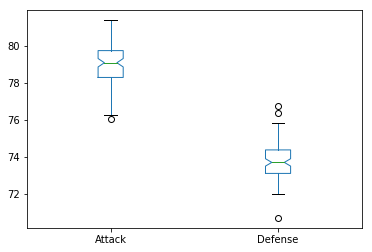

In [156]:
# Plot 95% confidence interval with a notch-box-plot
bootstrapped_values.plot.box(notch=True)

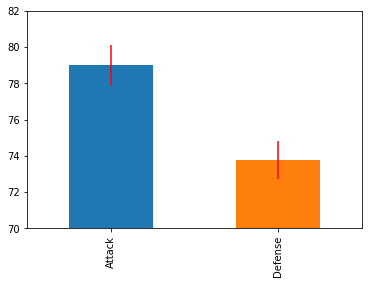

In [186]:
# Compare values and std with bar plots
bootstrapped_mean.plot.bar(yerr=bootstrapped_std, ecolor='r', ylim=[70, 82])

In [63]:
def CI_intervals_overlapping(tag1_data, tag2_data, alpha=0.05):
    """Calculate confidence intervals of the data and check for overlapping"""
    
    # Compute 95% confidence interval for tag1
    tag1_CI = (np.quantile(tag1_data, alpha/2), np.quantile(tag1_data, 1 - alpha/2))
    (lower_tag1, upper_tag1) = tag1_CI
    
    # Compute 95% confidence interval for tag2
    tag2_CI = (np.quantile(tag2_data, alpha/2), np.quantile(tag2_data, 1 - alpha/2))
    (lower_tag2, upper_tag2) = tag2_CI
    
    # Check if tag1 confidence interval overlaps with tag2 confidence interval
    overlapping = not ((lower_tag2 < lower_tag1 and upper_tag2 < lower_tag1)  \
                    or \
                    (lower_tag1 < lower_tag2 and upper_tag1 < lower_tag2))
    
    return tag1_CI, tag2_CI, overlapping

In [158]:
bootstrapped_mean, bootstrapped_std, bootstrapped_values = bootstrap(data[['Attack','Defense']], 100, lambda x: stats.pearsonr(x['Attack'], x['Defense'])[0])

In [163]:
np.quantile(bootstrapped_values, 0.975)

0.5210156201190121

In [164]:
np.quantile(bootstrapped_values, 0.025)

0.37334819107318484

In [167]:
two_sided_ci(bootstrapped_values, 0.05)

(0.37334819107318484, 0.5210156201190121)